#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


## Подготовка

### Загрузка библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

RANDOM_STATE = 42

### Загрузка данных

In [2]:
data = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])

### Обзор данных

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Данные представлены количеством заказов за каждые 10 мин.

### Проверка, что индекс монотонный

In [5]:
data.index.is_monotonic

True

### Ресемплирование по одному часу

In [6]:
data = data.resample('1H').sum()

## Анализ

### График временного ряда

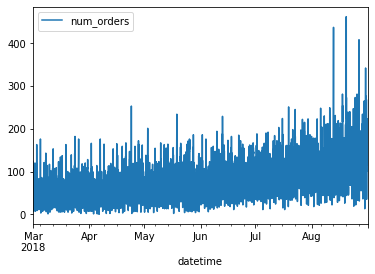

In [7]:
data.plot();

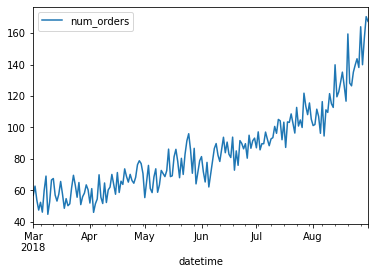

In [8]:
data.resample('1D').mean().plot();

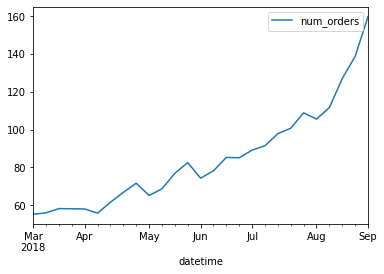

In [9]:
data.resample('1W').mean().plot();

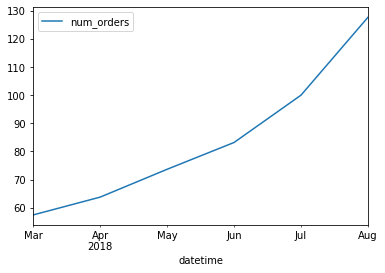

In [10]:
data.resample('1M').mean().plot();

### Разложение временного ряда на тренд, сезонность и остаток

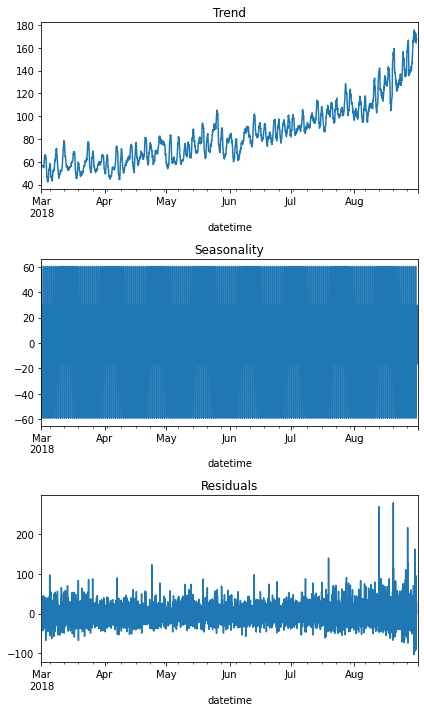

In [11]:
decomposed = seasonal_decompose(data)

plt.figure(figsize=(6, 10))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

### Сезонность

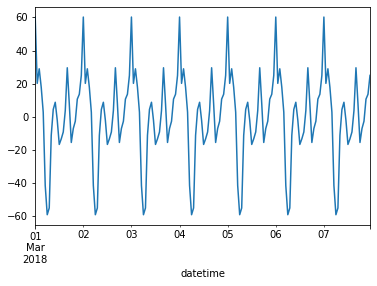

In [12]:
decomposed.seasonal.head(24*7).plot(ax=plt.gca());

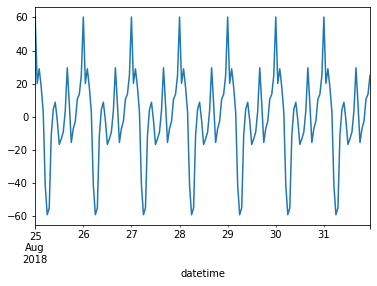

In [13]:
decomposed.seasonal.tail(24*7).plot(ax=plt.gca());

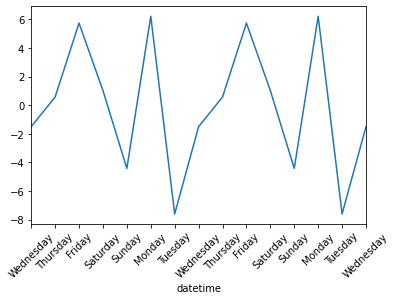

In [14]:
decomposition = seasonal_decompose(data.resample('1D').mean())
seasonal_component = decomposition.seasonal['2018-08-01':'2018-08-15']
ax = seasonal_component.plot(ax=plt.gca())
ax.set_xticks(seasonal_component.index)
ax.set_xticklabels(seasonal_component.index.day_name(), rotation=45)
plt.show();

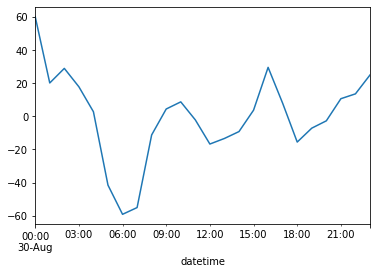

In [15]:
decomposed.seasonal['2018-08-30':'2018-08-30'].plot(ax=plt.gca());

### Разности временного ряда

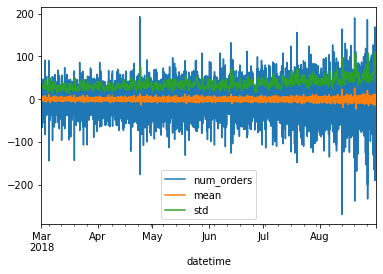

In [16]:
data_new = data - data.shift()
data_new['mean'] = data_new['num_orders'].rolling(15).mean()
data_new['std'] = data_new['num_orders'].rolling(15).std()
data_new.plot();

Имеется положительный тренд, количество заказов увеличивается. Имеется сезонность по дням, пик приходится с вечера на ночное время, спад рано утром, затем рост с началом рабочих часов. Если взять по дням недели, то вторник минимум заказов и в воскресенье тоже, пик это понедельник и пятница. Временной ряд стационарный.

## Обучение

### Создание календарных, отстающих  и скользящего среднего признаков

In [17]:
def make_features(data):
    df = data.copy()
    df['month'] = data.index.month
    df['day'] = data.index.day
    df['dayofweek'] = data.index.dayofweek
    df['hour'] = data.index.hour
    
    for lag in range(1, 6):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(1).mean()
    df.dropna(inplace=True)
    
    return df

In [18]:
df = make_features(data)

### Разделение данных на тренировочную и тестовую выборки

In [19]:
X = df.drop(['num_orders'], axis=1)
y = df['num_orders']

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.1, random_state=RANDOM_STATE)

### Обучение нескольких моделей

In [21]:
train_models = []

In [22]:
tscv = TimeSeriesSplit(n_splits=3)

### Линейная регрессия

In [23]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_train)
rmse = np.sqrt(mean_squared_error(y_train, y_pred))
print(f'RMSE: {rmse}')

RMSE: 30.49423537423937


In [24]:
train_models.append([model, rmse])

### DecisionTreeRegressor

In [25]:
model = DecisionTreeRegressor(random_state=RANDOM_STATE)
parameters = {'max_depth':range(1,11,2)}

gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=parameters)
gsearch.fit(X_train, y_train)
gsearch.best_params_
y_pred = gsearch.predict(X_train)
rmse = np.sqrt(mean_squared_error(y_train, y_pred))
print(f'RMSE: {rmse}')

RMSE: 22.023192400699568


In [26]:
train_models.append([model, rmse])

### RandomForestRegressor

In [27]:
model = RandomForestRegressor(random_state=RANDOM_STATE)
parameters = {'n_estimators':range(50,100,10), 'max_depth':range(1,11,2)}

gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=parameters)
gsearch.fit(X_train, y_train)
display(gsearch.best_params_)
y_pred = gsearch.predict(X_train)
rmse = np.sqrt(mean_squared_error(y_train, y_pred))
print(f'RMSE: {rmse}')

{'max_depth': 9, 'n_estimators': 80}

RMSE: 17.14855830604277


In [28]:
train_models.append([model, rmse])

### LightGBM

In [29]:
model = lgb.LGBMRegressor(random_state=RANDOM_STATE)
parameters = {'n_estimators':range(50,100,10), 'max_depth': range(1,11,2)}

gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=parameters)
gsearch.fit(X_train, y_train)
display(gsearch.best_params_)
y_pred = gsearch.predict(X_train)
rmse = np.sqrt(mean_squared_error(y_train, y_pred))
print(f'RMSE: {rmse}')

{'max_depth': 5, 'n_estimators': 90}

RMSE: 17.358925759415204


In [30]:
train_models.append([model, rmse])

## Тестирование

In [32]:
result = pd.DataFrame(train_models, columns=['model', 'rmse_train'])
pd.options.display.max_colwidth = 0
display(result.sort_values(by='rmse_train'))

,model,rmse_train
2,RandomForestRegressor(random_state=42),17.148558
3,LGBMRegressor(random_state=42),17.358926
1,DecisionTreeRegressor(random_state=42),22.023192
0,LinearRegression(),30.494235


In [34]:
model = RandomForestRegressor(random_state=RANDOM_STATE, max_depth=9, n_estimators=80)

model.fit(X_train, y_train)

y_test_pred = model.predict(X_test)

rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

print("RMSE тестовой выборки:", rmse_test)

RMSE тестовой выборки: 49.50143757783718


In [33]:
model = lgb.LGBMRegressor(random_state=RANDOM_STATE, max_depth=5, n_estimators=90)

model.fit(X_train, y_train)

y_test_pred = model.predict(X_test)

rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

print("RMSE тестовой выборки:", rmse_test)

RMSE тестовой выборки: 44.73909599193767


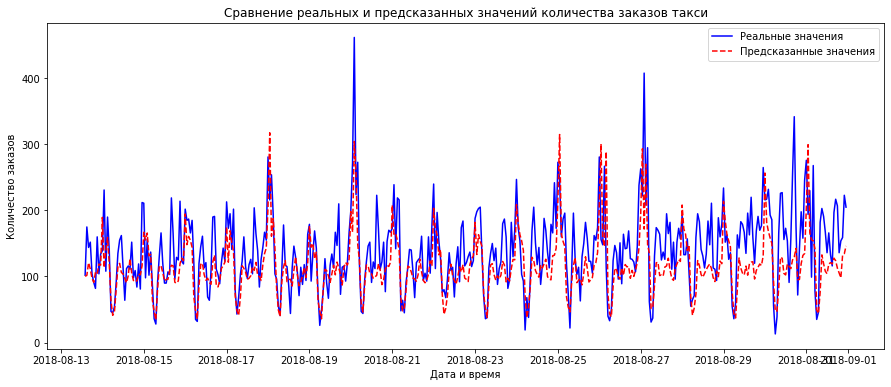

In [35]:
plt.figure(figsize=(15, 6))
plt.plot(y_test.index, y_test, label='Реальные значения', color='blue')
plt.plot(y_test.index, y_test_pred, label='Предсказанные значения', color='red', linestyle='--')
plt.title('Сравнение реальных и предсказанных значений количества заказов такси')
plt.xlabel('Дата и время')
plt.ylabel('Количество заказов')
plt.legend()
plt.show()

**Вывод**: Проверили несколько моделей, результаты на тренировочных данных хорошие, лучшей моделью оказались LGBMRegressor и RandomForestRegressor, но значение метрики RMSE на тестовой выборке не больше 48 получилось только у LGBMRegressor